In [1]:
''' import '''
import scipy.io as io
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt

In [2]:
''' load data '''
data = io.loadmat('./data/hw3_prob3.mat')

A = data['A']               # (30720, 65536)
b = data['b']               # (30720, 1)
x_orig = data['x_orig']     # (256, 256)

M, N = x_orig.shape
K, _ = b.shape

In [3]:
''' function '''
def trunc(z, t):
    return np.sign(z)*np.minimum(np.abs(z), t)

# Chambolle-Pock (2d)

In [4]:
''' TV '''
def D_h(x):
    return np.roll(x, -1, axis=0) - x

def D_h_T(x):
    return np.roll(x, 1, axis=0) - x

def D_v(x):
    return np.roll(x, -1, axis=1) - x

def D_v_T(x):
    return np.roll(x, 1, axis=1) - x

In [5]:
''' hyper param '''
MAXITER = 20000
CRIT = 5e-5

MU = 1
# LAMBDA = 0.2 # fn에만 사용됨

L = sla.norm(A)**2
tau = 1 / L
sigma = 1 / (tau*L)

In [6]:
''' Chambolle-Pock (2d) '''

fn_cham = []
xn_cham = []

x = np.zeros((M,N))
y1 = np.zeros((K,1))
y2 = np.zeros((M,N))
y3 = np.zeros((M,N))

for k in range(1, MAXITER):

    x = x.reshape(M, N)
    Dhx = D_h(x)
    Dvx = D_v(x)
    x = x.flatten()

    x_prev = x # x.flaten()과 차원이 같아야함

    # fn
    # fn = (MU/2)*la.norm(A@x - b)**2 + LAMBDA*la.norm(Dhx, 1) + LAMBDA*la.norm(Dvx, 1) # 계산량이 많음

    # update y
    ty1 = y1.flatten() + sigma*(A@x)
    ty2 = y2.flatten() + sigma*Dhx.flatten()
    ty3 = y3.flatten() + sigma*Dvx.flatten()

    y1 = (ty1 - sigma*MU*b.flatten()) / (1 + sigma*MU)
    y2 = trunc(ty2, sigma)
    y3 = trunc(ty3, sigma)

    # update x
    y2 = y2.reshape(M, N)
    y3 = y3.reshape(M, N)
    Dhty2 = D_h_T(y2)
    Dvty3 = D_v_T(y3)

    tx = x.flatten() - tau * (A.T@y1.flatten() + Dhty2.flatten() + Dvty3.flatten())
    x = np.maximum(tx, 0)

    theta = 1 / np.sqrt(1 + 2*MU*tau)
    tau = theta * tau
    sigma = sigma / theta

    x = x + theta*(x - x_prev) # acceleration

    # stop condition
    xcon = la.norm(x.flatten() - x_prev.flatten()) / la.norm(x.flatten())
    if (k >= 1) and (xcon < CRIT):
        break

    # history
    # fn_cham.append(fn)
    xn_cham.append(xcon)
    print(f'i = {k}, |x-x|/|x| = {xcon}')

# opt
x_cham = x

i = 1, |x-x|/|x| = 1.0
i = 2, |x-x|/|x| = 0.5993628261480592
i = 3, |x-x|/|x| = 0.41049654470021507
i = 4, |x-x|/|x| = 0.3043236105902254
i = 5, |x-x|/|x| = 0.2380892532095378
i = 6, |x-x|/|x| = 0.1937137126224767
i = 7, |x-x|/|x| = 0.16235075734668514
i = 8, |x-x|/|x| = 0.13922916782403258
i = 9, |x-x|/|x| = 0.12158776438611382
i = 10, |x-x|/|x| = 0.10773941070523237
i = 11, |x-x|/|x| = 0.09660677993676134
i = 12, |x-x|/|x| = 0.08747590808003733
i = 13, |x-x|/|x| = 0.07985819454425945
i = 14, |x-x|/|x| = 0.07340969583931775
i = 15, |x-x|/|x| = 0.06788216388079515
i = 16, |x-x|/|x| = 0.06309238210294328
i = 17, |x-x|/|x| = 0.05890241077642352
i = 18, |x-x|/|x| = 0.0552065319232018
i = 19, |x-x|/|x| = 0.05192241917906988
i = 20, |x-x|/|x| = 0.04898503703976602
i = 21, |x-x|/|x| = 0.046342342805625256
i = 22, |x-x|/|x| = 0.043952203771690165
i = 23, |x-x|/|x| = 0.041780149318656035
i = 24, |x-x|/|x| = 0.03979770677168569
i = 25, |x-x|/|x| = 0.03798115214499977
i = 26, |x-x|/|x| = 0.03631

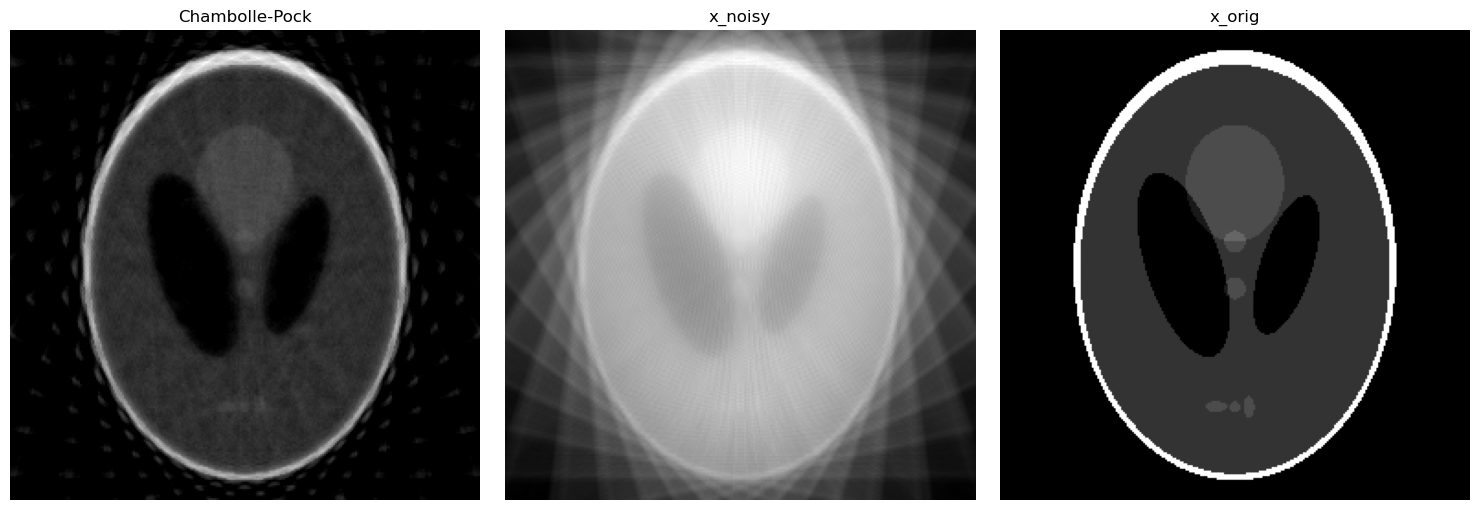

In [7]:
''' plot '''
x_noisy = A.T@b

_, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(x_cham.reshape(M,N, order='F'), cmap='gray')
axs[0].set_title('Chambolle-Pock')
axs[0].axis('off')

axs[1].imshow(x_noisy.reshape(M,N, order='F'), cmap='gray')
axs[1].set_title('x_noisy')
axs[1].axis('off')

axs[2].imshow(x_orig, cmap='gray')
axs[2].set_title('x_orig')
axs[2].axis('off')

plt.tight_layout()
plt.show()

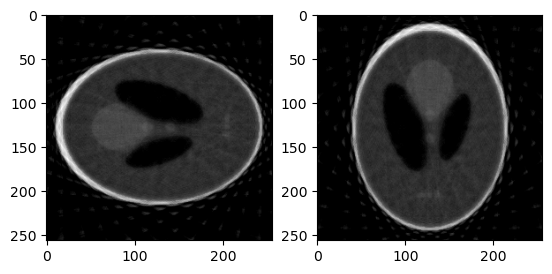

In [9]:
''' plt : imshow from 1d-vec '''
res1 = (x_cham.T).reshape(M,N)              # 작동 X :  메모리 저장 방식 불변
res2 = (x_cham).reshape(M,N, order='F')     # 작동 O :  불러오는 방식 변경

_, axs = plt.subplots(1,2)

axs[0].imshow(res1, cmap='gray')
axs[1].imshow(res2, cmap='gray')

plt.show()